In [1]:
!pip install datasets

     |████████████████████████████████| 306 kB 13.6 MB/s 
     |████████████████████████████████| 243 kB 70.3 MB/s 
     |████████████████████████████████| 132 kB 47.4 MB/s 
     |████████████████████████████████| 1.1 MB 63.7 MB/s 
     |████████████████████████████████| 61 kB 524 kB/s 
     |████████████████████████████████| 271 kB 76.1 MB/s 
     |████████████████████████████████| 192 kB 74.8 MB/s 
     |████████████████████████████████| 160 kB 10.4 MB/s 


In [2]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from datasets import load_dataset
from nltk.tokenize import ToktokTokenizer
from sklearn.metrics import f1_score
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
## Раскомментируйте и скачайте эмбеддинги
!wget  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
!gzip -d cc.ru.300.vec.gz

--2021-12-26 14:24:56--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1306357571 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ru.300.vec.gz’

cc.ru.300.vec.gz    100%[===================>]   1.22G  12.1MB/s    in 1m 44s  

2021-12-26 14:26:41 (11.9 MB/s) - ‘cc.ru.300.vec.gz’ saved [1306357571/1306357571]



# Deep Average Network для определения сентимента 

В этой домашке мы будет классифицировать твиты на 3 тональности.  
Вы будете использовать предобученные эмбеддинги слов, так что для начала обязательно нужно посмотреть [туториал по их использованию](https://github.com/BobaZooba/DeepNLP/blob/master/Tutorials/Word%20vectors%20%26%20Data%20Loading.ipynb).

Наши классы:  

Индекс | Sentiment  
-- | --  
0 | negative  
1 | neutral  
2 | positive  

Вам предстоит реализовать такую модель:
![Архитектура модели DAN](https://www.researchgate.net/profile/Shervin-Minaee/publication/340523298/figure/fig1/AS:878252264550411@1586403065555/The-architecture-of-the-Deep-Average-Network-DAN-10.ppm)

Что она из себя представляет:
- Мы подаем в нее индексы слов
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`

В этой домашке вам предстоит:
- Перевести тексты в матрицы с индексами токенов
- Реализовать модель
- Обучить ее
- Понять хорошо ли вы это сделали

Это очень важная модель, потому что она очень простая и показывает достаточно высокие метрики. В дальнейшем на работе советую использовать такую модель как бейзлайн. И в качестве эмбеддингов слов взять эмбеддинги от берта/роберты/тд.

## 🤗 Datasets
В этом туториале мы будем использовать подготовленные данные из библиотеки [datasets](https://github.com/huggingface/datasets). Мы вряд ли еще будем пользоваться этой библиотекой, так как нам будет важно самим подготавливать данные. Во-первых, для простоты, во-вторых, здесь есть достаточно неплохие практики. [Здесь](https://huggingface.co/datasets) вы сможете найти достаточно большое количество различных датасетов. Возможно, когда-нибудь они вам пригодятся.

## Загрузите эмбеддинги слов
Реализуйте функцию по загрузке эмбеддингов из файла. Она должна отдавать словарь слов и `np.array`
Формат словаря:
```python
{
    'aabra': 0,
    ...,
    'mom': 6546,
    ...
    'xyz': 100355
}
```
Формат матрицы эмбеддингов:
```python
array([[0.44442278, 0.28644582, 0.04357426, ..., 0.9425766 , 0.02024289,
        0.88456545],
       [0.77599317, 0.35188237, 0.54801261, ..., 0.91134102, 0.88599103,
        0.88068835],
       [0.68071886, 0.29352313, 0.95952505, ..., 0.19127958, 0.97723054,
        0.36294011],
       ...,
       [0.03589378, 0.85429694, 0.33437761, ..., 0.39784873, 0.80368014,
        0.76368042],
       [0.01498725, 0.78155695, 0.80372969, ..., 0.82051826, 0.42314861,
        0.18655465],
       [0.69263802, 0.82090775, 0.27150426, ..., 0.86582747, 0.40896573,
        0.33423976]])
```

Количество строк в матрице эмбеддингов должно совпадать с размером словаря, то есть для каждого токена должен быть свой эмбеддинг. По параметру `num_tokens` должно брать не более указано в этом параметре количество токенов в словарь и матрицу эмбеддингов.

In [4]:
def load_embeddings(file_path, pad_token='PAD', unk_token='UNK', max_words=100_000, verbose=True):
    """
    Делал по аналогии с туториалом: https://github.com/BobaZooba/DeepNLP/blob/master/Tutorials/Word%20vectors%20%26%20Data%20Loading.ipynb
    """
    vocab = dict()
    embeddings = list()

    with open(file_path) as file_object:

        vocab_size, embedding_dim = file_object.readline().strip().split()

        vocab_size = int(vocab_size)
        embedding_dim = int(embedding_dim)

        # в файле 1 000 000 слов с векторами, давайте ограничим для простоты этот словарь
        max_words = vocab_size if max_words <= 0 else max_words

        # добавим пад токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
        vocab[pad_token] = 0
        embeddings.append(np.zeros(embedding_dim))

        # добавим унк токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
        vocab[unk_token] = 1
        embeddings.append(np.ones(embedding_dim))

        progress_bar = tqdm(total=max_words, disable=not verbose, desc='Reading embeddings file')

        for line in file_object:
            parts = line.strip().split()

            token = ' '.join(parts[:-embedding_dim]).lower()

            if token in vocab:
                continue

            word_vector = np.array(list(map(float, parts[-embedding_dim:])))

            vocab[token] = len(vocab)
            embeddings.append(word_vector)

            progress_bar.update()

            if len(vocab) == max_words:
                break

        progress_bar.close()

    embeddings = np.stack(embeddings)
    
    # Необязательно задавать здесь
    # Это рекомендация к типу
    #token2index: Dict[str, int] = ...
    #embeddings_matrix: np.array = ...
    
    assert(len(vocab) == embeddings.shape[0])
    
    return vocab, embeddings

In [5]:
token2index, embeddings_matrix = load_embeddings('cc.ru.300.vec', max_words=100_000)

Reading embeddings file: 100%|█████████▉| 99998/100000 [00:08<00:00, 12160.86it/s]


In [6]:
embeddings_matrix.shape

(100000, 300)

## Загружаем данные из библиотеки
Мы сразу получим `torch.utils.data.Dataset`, который сможем передать в `torch.utils.data.DataLoader`

In [7]:
dataset_path = "tweet_eval"
dataset_name = "sentiment"

train_dataset = load_dataset(path=dataset_path, name=dataset_name, split="train")
valid_dataset = load_dataset(path=dataset_path, name=dataset_name, split="validation")
test_dataset = load_dataset(path=dataset_path, name=dataset_name, split="test")

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.53k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


## `torch.utils.data.DataLoader`

In [8]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

## Посмотрим что отдает нам `Loader`
Это батч формата:
```python
batch = {
    "text": [
        "text1",
        "text2",
        ...,
        "textn"
    ],
    "label": tensor([
        1,
        1,
        ...,
        0
    ])
}
```
То есть у нас есть словарь с двумя ключами `text` и `label`, где хранится n примеров. То есть для 5-го примера в батче текст будет храниться в `batch["text"][5]`, а индекс класса будет храниться в `batch["label"][5]`.

In [9]:
for batch in train_loader:
    break

batch

{'label': tensor([0, 0]),
 'text': ['"if I don\'t see Ed Sheeran in concert I\'m going to drown myself, I\'ve been wanting to see him since the 7th Grade"',
  '@user What makes me almost as angry as #legitimaterape is that I may vote for @user even though she supported PIPA. Lesser evil...']}

## Collate
Сейчас перед нами стоит проблема: мы получаем тексты в виде строк, а нам нужны тензоры (матрицы) с индексами токенов, к тому же нам нужно западить последовательности токенов, чтобы все сложить в торчовую матрицу. Мы можем сделать это двумя способами:
- Достать из `train/valid/test_dataset` данные и написать свой `Dataset`, где внутри будет токенизировать текст, токены будут переводиться в индексы и затем последовательность будет падиться до нужной длины
- Сделать функцию, которая бы дополнительно обрабатывали наши батчи. Она вставляется в `DataLoader(collate_fn=<ВАША_ФУНКЦИЯ>)`

## Если вы хотите сделать свой `Dataset`
То вы можете достать данные таким образом.

In [10]:
len(train_dataset["text"]), len(train_dataset["label"])

(45615, 45615)

In [11]:
train_dataset["text"][:2]

['"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"',
 '"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"']

In [12]:
train_dataset["label"][:2]

[2, 1]

## Если вы хотите сделать `collate_fn`

### Давайте посмотрим что вообще происходит внутри этого метода
Для этого сделаем функцию `empty_collate`, которая принимает на вход батч и отдает его, ничего с ним не делая

In [13]:
def empty_collate(batch):
    return batch

In [14]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=empty_collate)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)

In [15]:
for batch in train_loader:
    break

batch

[{'label': 2,
  'text': '@user I think Thor is B-list like Kriss said b/c he\'s probably one of the 1st names you know if you read comics, but otherwise no idea"'},
 {'label': 2,
  'text': '@user Live stream of Apple event requires &lt;long list of Apple stuff&gt;, or a PC with Microsoft Edge on Windows 10.'}]

## Формат батча
```python
batch = [
    {
        "text": "text1",
        "label": 0
    }, 
    {
        "text": "text2",
        "label": 1
    },
    ...,
    {
        "text": "textn",
        "label": 1
    }
]
```
То есть теперь у нас есть список, где каждый элемент — это словарь со значениями `text` и `label`.  

Вы можете сделать функцию или класс с методом `collate`. Этот способ решения домашки предодчтительней, так как использовать `collate` очень хорошая практика.

Что я предлагаю:
- Сделайте класс `Tokenizer`

In [16]:
from itertools import groupby

In [17]:
class Tokenizer:
    
    def __init__(self, base_tokenizer, token2index, pad_token, unk_token, max_length):
        
        self._base_tokenizer = base_tokenizer  # например ToktokTokenizer()
        
        self.token2index = token2index  # словарь из load_embeddings()
        
        self.pad_token = pad_token
        self.pad_index = self.token2index[self.pad_token]
        
        self.unk_token = unk_token
        self.unk_index = self.token2index[self.unk_token]
        
        self.max_length = max_length

    def tokenize(self, text):
        """
        В этом методе нужно разделить строку текста на токены
        """
        return self._base_tokenizer.tokenize(text)
    
    def indexing(self, tokenized_text):
        """
        В этом методе нужно перевести список токенов в список с индексами этих токенов
        """
        return [self.token2index[token] if token in self.token2index else self.unk_index for token in tokenized_text]
        
    def padding(self, tokens_indices):
        """
        В этом методе нужно сделать длину tokens_indices равной self.max_length
        Опционально убрать повторяющиеся unk'и
        """
        new_tokens = list()
        for group in groupby(tokens_indices):
            if group[0] == self.unk_index:
                new_tokens.append(self.unk_index)
            else:
                new_tokens.extend(group[1])               
        
        new_length = len(new_tokens)
        if new_length > self.max_length:
            return new_tokens[:self.max_length] 
        return new_tokens + [self.pad_index] * (self.max_length - new_length)
    
    def __call__(self, text):
        """
        В этом методе нужно перевести строку с текстом в вектор с индексами слов нужно размера (self.max_length)
        """
        return self.padding(self.indexing(self.tokenize(text)))
        
    def collate(self, batch):
        
        tokenized_texts = list()
        labels = list()
        
        for sample in batch:
            labels.append(sample["label"])
            tokenized_texts.append(self(sample["text"]))
            
            
        tokenized_texts = torch.tensor(tokenized_texts)  # перевод в torch.Tensor
        labels = torch.tensor(labels)  # перевод в torch.Tensor
        
        return tokenized_texts, labels

## Перед реализацией выбранного метода
Советую, чтобы в итоге `Loader` отдавал кортеж с двумя тензорами:
- `torch.Tensor` с индексами токенов, размерность `(batch_size, sequence_length)`
- `torch.Tensor` с индексами таргетов, размерность `(batch_size)`

То есть, чтобы было так:
```python
for x, y in train_loader:
    ...

>> x
>> tensor([[   37,  3889,   470,  ...,     0,     0,     0],
           [ 1509,   581,   144,  ...,     0,     0,     0],
           [ 1804,   893,  2457,  ...,     0,     0,     0],
           ...,
           [  170, 39526,  2102,  ...,     0,     0,     0],
           [ 1217,   172, 28440,  ...,     0,     0,     0],
           [   37,    56,   603,  ...,     0,     0,     0]])

>> y
>> tensor([1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1,
           0, 2, 1, 1, 0, 1, 2, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0,
           1, 0, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 0, 1, 0, 2, 1, 2, 2, 1, 0, 0, 2, 2,
           2, 1, 2, 0, 2, 2, 0, 2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 2,
           2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 1,
           2, 1, 1, 2, 2, 1, 1, 2])

>> x.shape
>> torch.Size([128, 64])

>> y.shape
>> torch.Size([128])
```
При условии, что батч сайз равен 128, а максимальная длина последовательности равна 64.

## Помните

## <Место для реализации>

In [18]:
tokenizer = Tokenizer(ToktokTokenizer(), token2index, "PAD", "UNK", 30)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=tokenizer.collate)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, collate_fn=tokenizer.collate)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=tokenizer.collate)

In [20]:
for x, y in train_loader:
    break

In [21]:
assert(isinstance(x, torch.Tensor))
assert(len(x.size()) == 2)

assert(isinstance(y, torch.Tensor))
assert(len(y.size()) == 1)

# Реализация DAN

На вход модели будут подавать индексы слов

Шаги:
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`
    - Нужно реализовать самому
    
Дополнительно:
- Добавьте `nn.Dropout`, `nn.BatchNorm` по вкусу
- Сделайте усреднение с учетом падов
- Используйте эмбеддинги от берта/роберты/тд (когда-нибудь про это будет целый туториал, а пока предлагают вам попробовать сделать это самим)

# Советы

## До обучения
- Выберите метрику(ки) качества и расскажите почему она(они)
    - Обычно есть основная метрика, по которой принимаем решения какие веса брать и дополнительные, которые нам помогут делать выводы, например, о том все ли хорошо с нашими данными, хорошо ли модель справляется с дисбалансом классов и тд
- Эту домашку можно сделать и на `CPU`, но на `GPU` будет сильно быстрее
    - Во всех остальных домашках мы будем учить модели на `GPU`
    - Рано или поздно вам придется посмотреть этот [туториал](https://www.youtube.com/watch?v=pgk1zGv5lU4)
    - Вы можете обучаться на `colab`, это бесплатно

## До эпохи
- Сделайте списки/словари/другое, чтобы сохранять нужные данные для расчета метрик(и) по всей эпохе для трейна и валидации

## Во время эпохи
- Используйте [`tqdm`](https://github.com/tqdm/tqdm) как прогресс бар, чтобы понимать как проходит ваше обучение
- Логируйте лосс
- Логируйте метрику(ки) по батчу
- Сохраняйте то, что вам нужно, чтобы посчитать метрик(и) на всю эпоху для трейна и валидации

## После эпохи
- Посчитайте метрик(и) на всю эпоху для трейна и валидации

## После обучения
- Провалидируйтесь на тестовом наборе и посмотрите метрики
- Постройте [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- Постройте графики:
    - [Confusion Matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)
    - [Опционально] Распределение вероятностей мажоритарного класса (то есть для какого-то примера мы выбираем такой класс и вероятность этого выбора такая-то) на трейне/тесте/валидации
        - Если класс был выбран верно и если была ошибка
- Подумайте что еще вам будет полезно для того, чтобы ответить на такие вопросы: 
    - Что в моделе можно улучшить?
    - Все ли хорошо с моими данными?
    - Все ли хорошо с валидацией?
    - Не переобучился ли я?
    - Достаточно ли я посмотрел на данные?
    - Нужно ли мне улучшить предобработку данных?
    - Нужно ли поменять токенизацию или эмбеддинги?
    - Нет ли у меня багов в реализации?
    - Какие типичные ошибки у моей модели?
    - Как я могу их исправить?

# Я выбрал метрику F1-weighted
Почему я выбрал эту метрику:  
Мы можем проанализировать распределение в данных для обучения таргета:
- "0" - 3972
- "1" - 5937
- "2" - 2375

 Становится понятно, что присутствиует дисбаланс классов и чтобы отразить максимально праивльно получаемую метрику (чтобы не было ситуации когда по маленькому классу большая f1 ввиду его размера, а при усреднении этот f1 будет иметь такое же влияние)


In [42]:
class DeepAverageNetwork(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 embeddings_matrix, 
                 hidden_size,
                 output,  
                 dropout):
        
        super(DeepAverageNetwork, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim).from_pretrained(torch.Tensor(embeddings_matrix), freeze=True)
        self.linear_in = nn.Linear(embedding_dim, hidden_size)
        self.linear_out = nn.Linear(hidden_size, output)
        self.batchnorm = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()      
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embeddings = self.embedding(text)        
        embeddings_mean = torch.mean(embeddings, dim=1)
        linear_in = self.relu(self.batchnorm(self.linear_in(embeddings_mean)))
        after_droput = self.dropout(linear_in)
        linear_out = self.linear_out(after_droput)
        return linear_out

In [54]:
model = DeepAverageNetwork(embeddings_matrix.shape[0], embeddings_matrix.shape[-1], embeddings_matrix,
                          16, 3, 0.1)

In [55]:
model

DeepAverageNetwork(
  (embedding): Embedding(100000, 300)
  (linear_in): Linear(in_features=300, out_features=16, bias=True)
  (linear_out): Linear(in_features=16, out_features=3, bias=True)
  (batchnorm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

## Задайте функцию потерь и оптимизатор

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = torch.nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

## Сделайте цикл обучения

In [57]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [58]:
from torch.nn import functional as F

In [59]:
def train(model, iterator, optimizer, criterion, last_n_losses=500):
    train_losses = list()
    train_f1 = list()

    model.train()
    for i, (x, y) in tqdm(enumerate(iterator), total=len(iterator)):
        optimizer.zero_grad()        
        predictions = model(x.to(device)).squeeze() 
        loss = criterion(predictions, y.to(device))        
        loss.backward()
        optimizer.step()
        predictions = F.softmax(predictions, dim=1)
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = y.tolist()
        
        train_f1.append(f1_score(y_true, preds, average="weighted"))       
        train_losses.append(loss.item())
        
    return np.mean(train_losses), np.mean(train_f1)

def evaluate(model, iterator, criterion, last_n_losses=500):
    val_losses = list()
    val_f1 = list()
    
    model.eval()
    with torch.no_grad():
        for i, (x, y) in tqdm(enumerate(iterator), total=len(iterator)):
            predictions = model(x.to(device)).squeeze()
            loss = criterion(predictions, y.to(device))
            predictions = F.softmax(predictions, dim=1)
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = y.tolist()
            
            val_losses.append(loss.item())
            val_f1.append(f1_score(y_true, preds, average="weighted"))
    
    return np.mean(val_losses), np.mean(val_f1)

In [60]:
NUM_EPOCHS = 10  # Задайте количество эпох

train_losses = list()
train_f1 = list()
val_losses = list()
val_f1 = list()

for n_epoch in range(NUM_EPOCHS):
    # train
    t_loss, t_f1 = train(model, train_loader, optimizer, criterion)    
    train_losses.append(t_loss)
    train_f1.append(t_f1)
    
    print(f'Epoch: {n_epoch}\n')
    print(f'Train: loss - {t_loss} | f1-weight - {t_f1}\n')

    # validation
    v_loss, v_f1 = evaluate(model, valid_loader, criterion)
    val_losses.append(v_loss)
    val_f1.append(v_f1)
    
    print(f'Validation: loss - {v_loss} | f1-weight - {v_f1}\n')
    
# test
y_true = list()
y_pred = list()
with torch.no_grad():
    for (x, y) in test_loader:
        predictions = model(x.to(device)).squeeze()
        predictions = F.softmax(predictions, dim=1) 
        y_true.extend(y.tolist())
        y_pred.extend(predictions.detach().to('cpu').numpy().argmax(1).tolist())


print(classification_report(y_true, y_pred))

100%|██████████| 357/357 [00:06<00:00, 52.69it/s]


Epoch: 0

Train: loss - 1.1561916505589205 | f1-weight - 0.29814922798921434



100%|██████████| 16/16 [00:00<00:00, 57.67it/s]


Validation: loss - 1.1201431155204773 | f1-weight - 0.2996450775099521



100%|██████████| 357/357 [00:06<00:00, 53.24it/s]


Epoch: 1

Train: loss - 1.1197247087788516 | f1-weight - 0.3140666726950248



100%|██████████| 16/16 [00:00<00:00, 54.16it/s]


Validation: loss - 1.1024228855967522 | f1-weight - 0.32837098517177055



100%|██████████| 357/357 [00:06<00:00, 52.49it/s]


Epoch: 2

Train: loss - 1.1027936437884633 | f1-weight - 0.34687710835900276



100%|██████████| 16/16 [00:00<00:00, 59.75it/s]


Validation: loss - 1.0942943543195724 | f1-weight - 0.36195709839892565



100%|██████████| 357/357 [00:06<00:00, 52.24it/s]


Epoch: 3

Train: loss - 1.0876760148868507 | f1-weight - 0.37762927566125915



100%|██████████| 16/16 [00:00<00:00, 55.52it/s]


Validation: loss - 1.0725507661700249 | f1-weight - 0.4068821592860108



100%|██████████| 357/357 [00:06<00:00, 52.69it/s]


Epoch: 4

Train: loss - 1.0738495374594081 | f1-weight - 0.40364636201081905



100%|██████████| 16/16 [00:00<00:00, 57.44it/s]


Validation: loss - 1.0647429749369621 | f1-weight - 0.42032954553078095



100%|██████████| 357/357 [00:06<00:00, 53.39it/s]


Epoch: 5

Train: loss - 1.0592685169866438 | f1-weight - 0.429270637280685



100%|██████████| 16/16 [00:00<00:00, 59.95it/s]


Validation: loss - 1.0502614751458168 | f1-weight - 0.442053978475504



100%|██████████| 357/357 [00:06<00:00, 52.95it/s]


Epoch: 6

Train: loss - 1.045460937403831 | f1-weight - 0.44912489064457223



100%|██████████| 16/16 [00:00<00:00, 60.03it/s]


Validation: loss - 1.04856638610363 | f1-weight - 0.4508678951933065



100%|██████████| 357/357 [00:06<00:00, 52.37it/s]


Epoch: 7

Train: loss - 1.0374633307550467 | f1-weight - 0.45878297217239733



100%|██████████| 16/16 [00:00<00:00, 56.66it/s]


Validation: loss - 1.0312947742640972 | f1-weight - 0.4654951100627397



100%|██████████| 357/357 [00:06<00:00, 53.34it/s]


Epoch: 8

Train: loss - 1.0283373499116977 | f1-weight - 0.4668813873663917



100%|██████████| 16/16 [00:00<00:00, 56.78it/s]


Validation: loss - 1.0304704681038857 | f1-weight - 0.47107668047345097



100%|██████████| 357/357 [00:06<00:00, 53.40it/s]


Epoch: 9

Train: loss - 1.0206726151688092 | f1-weight - 0.47427539336777



100%|██████████| 16/16 [00:00<00:00, 59.00it/s]


Validation: loss - 1.0195241309702396 | f1-weight - 0.4778518231564592

              precision    recall  f1-score   support

           0       0.50      0.13      0.21      3972
           1       0.56      0.71      0.63      5937
           2       0.27      0.42      0.33      2375

    accuracy                           0.47     12284
   macro avg       0.44      0.42      0.39     12284
weighted avg       0.48      0.47      0.43     12284



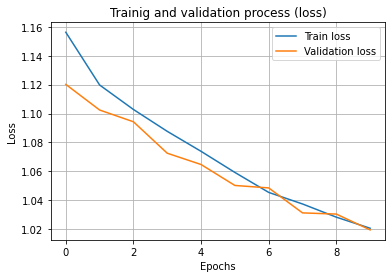

In [61]:
plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Trainig and validation process (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss');
plt.legend()
plt.grid()

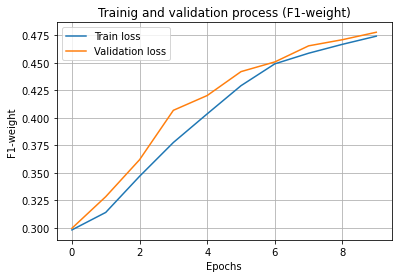

In [62]:
plt.figure()
plt.plot(train_f1, label='Train loss')
plt.plot(val_f1, label='Validation loss')
plt.title('Trainig and validation process (F1-weight)')
plt.xlabel('Epochs')
plt.ylabel('F1-weight');
plt.legend()
plt.grid()

In [63]:
from sklearn.metrics import confusion_matrix

In [64]:
conf_matrix = confusion_matrix(y_true, y_pred)

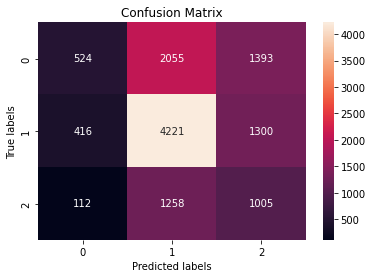

In [65]:
#https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

# Выводы
Напишите небольшой отчет о проделанной работе. Что удалось, в чем не уверены, что делать дальше.

Интересное задание. Первое впечатление от полученной модели - ей очень не хвататет данных для обучения ввиду усреднения эмбеддингов слов предложения. Если бы стояла задача по улучшению получаемой модели, то я бы смотрел в эту сторону.

Также инетерсная матрица ошибок - она хорошо показывает на то, как плохо распознается класс "0" (Негативные сообщения) и что значимая часть переезжает в класс "1". Также видно что как раз этот класс 1 лучше всего распознается опять же ввиду дисбалана классов и саому определению нейтрального эмоционального окраса (можно предположить, что усреденение вектора эмбеддингов для нейтрального класса работает как раз хорошо, чего нельзя сказать про позитив и негавтив, где решаюшую роль может занимать одно слово, которое в итоге и будет определять принадлежность к классу). 

Также получились хорошие графики метрики и лоссов, видно что learning rate выбран хорошо и нормально подобрано необходимое количество эпох. Я пробовал и другие параметры, однако при установленных значениях learning rate получилась наилучшие результаты.